In [64]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import t
%matplotlib inline

In [65]:
file_location = "/Users/mingchang/Downloads/"
file_name = "python_project_experiment_data.csv"
my_data = pd.read_csv(file_location + file_name)

In [66]:
my_data.date = pd.to_datetime(my_data.date, format='%Y-%m-%d')
my_data.head()

,country,date,experiment_id,order_id,spend_usd,user_bucket,user_id,vertical
0,IT,2017-04-01,12624549,1593533581388680355,3.799427,12,3454648139452205402,GAMES
1,BR,2017-04-01,12624548,5746748877810015202,2.546213,9,9303514494910504425,GAMES
2,NZ,2017-04-07,12624548,17361185188659735484,13.449449,2,13625318472882626688,GAMES
3,US,2017-04-02,12624549,13365437971635537789,19.990000,5,11936268987816495850,GAMES
4,US,2017-04-03,12624549,13876597780924571273,19.990000,5,11936268987816495850,GAMES


In [67]:
# plot
def GetDailySeries(my_data, my_id):
    table = my_data[["date", "spend_usd"]][my_data.experiment_id == my_id]
    series = table.groupby('date')['spend_usd'].sum()
    return series

def GetDailyCumulativeSeries(my_data, my_id):
    table = my_data[["date", "spend_usd"]][my_data.experiment_id == my_id]
    series = table.groupby('date')['spend_usd'].sum()
    series = np.cumsum(series)
    return series

def PlotSeries(experiment_series, control_series):
    fig, ax = plt.subplots()
    ax.plot(experiment_series, color="red", label="experiment")
    ax.plot(control_series, color="blue", label="control")
    ax.set_title("Red vs. Blue")
    ax.set_ylabel("Total spend")
    ax.grid(True, which="both")
    ax.legend()
    plt.gcf().autofmt_xdate()
    
def PlotCumulativeTimeSeries(my_data, experiment_id, control_id):
    # data grouping
    my_data = my_data.sort_values("date", ascending=True, inplace=False)
    treatment_series = GetDailyCumulativeSeries(my_data, experiment_id)
    control_series = GetDailyCumulativeSeries(my_data, control_id)    
    PlotSeries(treatment_series, control_series)

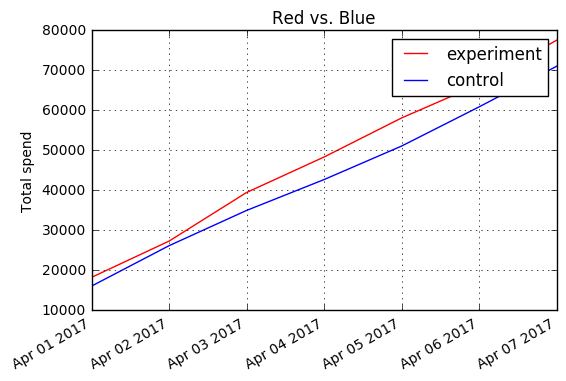

In [68]:
PlotCumulativeTimeSeries(my_data, 12624548,12624549)

In [69]:
# jackknife
def GetUserBucket(my_data, my_id):
    table = my_data[["user_bucket","spend_usd"]][my_data.experiment_id == my_id]
    series = table.groupby("user_bucket")["spend_usd"].sum()
    return series

def JackknifeStandardErrorTwoSample(exp_series, ctr_series):    
    n_buckets = len(exp_series)
  
    exp_sum = sum(exp_series)
    ctr_sum = sum(ctr_series)
    exp_metric = exp_sum / float(n_buckets)
    ctr_metric = ctr_sum / float(n_buckets)
  
    metric_diff = exp_metric - ctr_metric

    jackknife_sum_squares = 0.0
    exp_series = exp_series.tolist()
    ctr_series = ctr_series.tolist()
  
    for i in range(n_buckets):
        jackknife_bucket = (exp_sum - exp_series[i]) / float(n_buckets - 1) \
            - (ctr_sum - ctr_series[i]) / float(n_buckets - 1)            
        jackknife_sum_squares += (jackknife_bucket - metric_diff) ** 2
  
    metric_se = math.sqrt(jackknife_sum_squares * ((n_buckets - 1) / float(n_buckets)))
    return metric_diff, metric_se

In [ ]:
# draw confidence interval

In [70]:
def CreateTConfidenceInterval(overall_metric,
                              metric_se,
                              n_buckets=20,
                              confidence_level=0.05):
    t_rv = t(n_buckets - 1)
    t_statistic = t_rv.ppf(1 - confidence_level / 2.0)

    upper_bound = overall_metric + t_statistic * metric_se
    lower_bound = overall_metric - t_statistic * metric_se
    return lower_bound, upper_bound

In [71]:
def GetCumulativeUserBucket(my_data, my_id, until_date):
    table = my_data[["user_bucket","date","spend_usd"]][my_data.experiment_id == my_id]
    series = table[table.date <= until_date].groupby("user_bucket")["spend_usd"].sum()
    return series

In [72]:
# plot cumulative confidence interval on difference
def PlotCumulativeTimeSerieswithCI(my_data, exp_id, ctr_id, confidence_level=0.05):
    days_ = []
    value_ = []
    lower_ = []
    upper_ = []
    baseline_ = []
    my_dates = my_data.date.unique()

    for unique_day in my_dates:
        exp_series = GetCumulativeUserBucket(my_data, exp_id, unique_day)
        ctr_series = GetCumulativeUserBucket(my_data, ctr_id, unique_day)
        baseline_.append(0.0)
        
        metric, se = JackknifeStandardErrorTwoSample(exp_series, ctr_series)
        lower, upper = CreateTConfidenceInterval(metric, se)
        control = sum(ctr_series)

        days_.append(unique_day)

        value_.append(metric / control)
        lower_.append(lower / control)
        upper_.append(upper / control)

    # our final CI
    lower_bound_pct = round(lower_[-1]*100,2)
    upper_bound_pct = round(upper_[-1]*100,2)
    avg_metric_pct = round(value_[-1]*100,2)
    is_stat_sig = "YES" if lower_bound_pct>0 or upper_bound_pct<0 else "NO"
    
    print "Treatment", exp_id
    print "  Jackkinfe confidence interval: [{0}%, {1}%]".format(
        lower_bound_pct, upper_bound_pct)
    print "  Statistical significance: {0}".format(is_stat_sig)
        
    # draw the chart
    final_data = pd.DataFrame(
        {
            'date': days_,
            'value': value_,
            'upper': upper_,
            'lower': lower_,
            'baseline': baseline_
        },
        index = days_,
        columns=['date','value','upper','lower','baseline']).sort_values(by='date', ascending=True)

    fig, ax = plt.subplots()
    ax.plot(final_data.index, final_data.value, color="blue")
    ax.plot(final_data.index, final_data.baseline, color="black")
    ax.fill_between(final_data.index, final_data.lower, final_data.upper, color="blue", alpha=0.3)
    ax.grid(True, which="both")
    plt.gcf().autofmt_xdate()

Treatment 12624548
  Jackkinfe confidence interval: [-0.76%, 1.69%]
  Statistical significance: NO


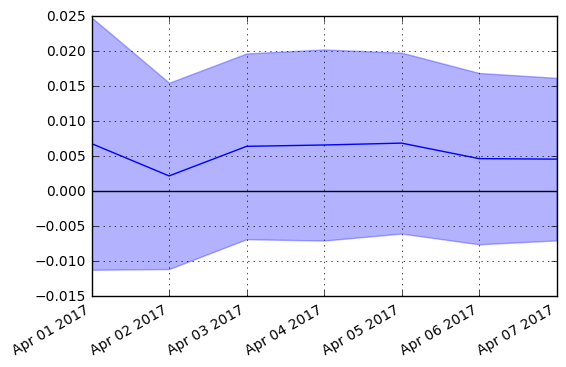

In [73]:
PlotCumulativeTimeSerieswithCI(my_data,12624548,12624549)